## An example of a simple trend-following strategy on one instrument. The strategy is tested on synthetic continuous NQ futures on the CME.

### Strategy Logic
<br>

$$
\text{position} = \frac{\text{EMA of log return signal}}{\text{signal vol}\times{\text{asset vol}}}\times \text{scale}
$$

- **EMA of log return signal**:
<br>- The **Exponential Moving Average (EMA)** of log returns is calculated over a defined look-back period.
<br>- A **positive EMA** signals strength, indicating a **long entry**.
<br>- A **negative EMA** signals weakness, indicating a **short entry**.

- **signal vol**: signal volatility, measured using 200 EMA of absolute log returns

- **asset vol**: NQ return volatility, measured using a double EMA (smoothed twice by 20 then 200 period) of absolute log returns.

- **scale**: adjust the impact of volatility on the final signal calculation

- **position**: the position size is inversely proportional to signal volatility and asset volatility. This dynamic sizing helps reduce exposure during volatile periods. Additionally, the position is capped by an upper/lower limit of *±pos_limit* lot.

### Parameters to Optimize:
1. **period**: The look-back period for the EMA of log returns, used to generate trading signals.
2. **scale**: Scaling factor used to adjust the target position based on volatility.

In [27]:
!pip install pyfolio_reloaded

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 1.2 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 867.7 kB/s eta 0:00:00a 0:00:01
  Created wheel for peewee: filename=peewee-3.17.3-py3-none-any.whl size=138487 sha256=0a4b43081907bd72bd22d79a18ee633733d1caf15351d1752569473c73619d86
  Stored in directory: /Users/alexanderovodkov/Library/Caches/pip/wheels/39/c7/dd/909d267742f7fbb941ff081dacd661f622a0b4eb38f667b84b
Successfully built peewee


Loading necessary libraries:

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import datetime
from tqdm.notebook import tqdm

Function for reading data from a file:

In [124]:
def read_data(ticker):
    """
    Read logarithmic returns from file

    :ticker: ticker of continious futures
    """
    # You need to insert the path to the data file
    data = 'NQ.csv'
    data = pd.read_csv(ticker+'.csv', index_col = 'date')
    #All datasets for this course are available at this link:
    #https://drive.google.com/drive/folders/1mhbVjuwNZGX9nmZuCxJStBmraF3HIzio?usp=sharing

    # Parse timestamps
    data.index = pd.to_datetime(data.index, format = "%Y-%m-%d %H:%M:%S")

    return data

Functions for calculating some standard statistics:

In [125]:
days_in_year = 365.25
# Most packages use a constant of 252 trading days per year, but here we use calendar days by adding zero returns on weekends.
# This approach is used to allow for backtesting strategies that trade a portfolio of instruments on different exchanges and in different timezones.
# Trading hours on one exchange may fall on weekends on another.

def Return(rets):
    """
    Annual return estimate

    :rets: daily returns of the strategy
    """
    return np.mean(rets)*days_in_year


def Volatility(rets):
    """
    Estimation of annual volatility

    :rets: daily returns of the strategy
    """
    return np.std(rets)*np.sqrt(days_in_year)


def SharpeRatio(rets):
    """
    Estimating the annual Sharpe ratio

    :rets: daily returns of the strategy
    """
    volatility = Volatility(rets)
    if (volatility>0):
        return Return(rets)/volatility
    else:
        return float('NaN')

def statistics_calc(rets, bh, name = '_', plot = False):
    """
    Draws a graph of portfolio equity and calculates annual Sharpe ratios, profitability and volatility

    :rets: daily returns of the strategy
    """
    sharpe = SharpeRatio(rets)
    ret = Return(rets)
    vol = Volatility(rets)
    if plot:
        plt.plot(rets.cumsum(), label = 'strategy')
        plt.plot(bh.cumsum(), label = 'buy & hold')
        plt.xlabel('t')
        plt.legend()
        print('Sharpe ratio = %0.2f'%sharpe)
        print('Annual Return = %0.2f'%ret)
        print('Annual Std = %0.2f'%vol)
    return  pd.DataFrame([[sharpe, ret, vol]], columns = ['Sharpe ratio', 'Annual return', 'Volatility'], index = [name])

Reading data:

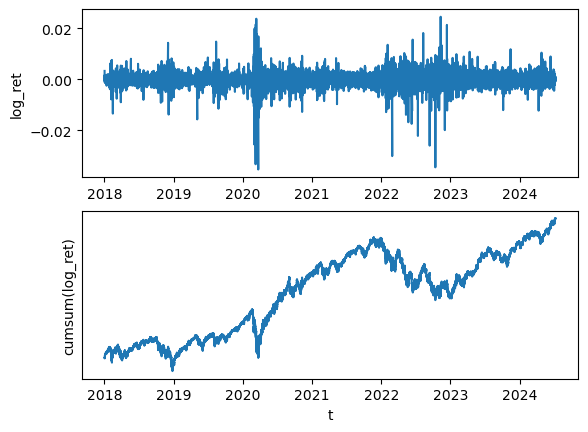

In [126]:
data = read_data('NQ')

# Let's draw graphs
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(data)
ax1.set_ylabel('log_ret')

ax2.plot(data.cumsum())
ax2.set_yticks([])
ax2.set_ylabel('cumsum(log_ret)')
_ = ax2.set_xlabel('t')

p = True
if p == True:
    plt.show()
    p = False

Prepare train and test samples:

In [127]:
data = read_data('NQ')
in_sample_start = '2018-01-01'
in_sample_end = '2022-01-01'

train = data[in_sample_start:in_sample_end]
test = data[in_sample_end:]
train_test = data[in_sample_start:]

Function for strategy logic and backtest calculation:

In [128]:
def strategy_backtest(data, params, plot = False, in_sample_end = '', slippage = 0.00001):
    """
    Strategy backtest calculation
    Example call:
    strategy_bactest(test, [period, scale])

    :data: dataframe with log returns
    :params: list of strategy parameters
    :plot: if True than equity curve is plotted
    :in_sample_end: string in format "%Y-%m-%d" with timestamp of in_sample_end. Only used on charts
    :slippage: slippage per trade

    :return: statistics and equity curve
    """

    # Strategy parameters that we will optimize
    period = params[0]
    scale = params[1]

    # Calculation of target position:

    features = pd.DataFrame(index = data.index)

    # We calculate the exponential moving average of increments:
    features['signal'] = data['log_ret'].ewm(period).mean()

    # Estimating signal volatility using exponential moving average
    features['absSignal'] = np.abs(features['signal']).shift(1)
    features['signal_vol'] = features['absSignal'].ewm(200).mean()+0.000000001 #0.000000001 is to prevent value=0 that could cause Devision by Zero error

    # Estimating asset volatility using double exponential moving average:
    features['absRet'] = np.abs(data['log_ret'])
    features['EmaAbsRet'] = features['absRet'].ewm(20).mean().shift(1)*np.sqrt(20)
    features['vol'] = features['EmaAbsRet'].ewm(200).mean()*np.sqrt(200)+0.000000001

    # Calc target position:
    features['position'] = ((features['signal']/features['signal_vol']/features['vol']*scale).shift(1)).fillna(0).astype(int)

    # We remove looking into the future
    # (we cannot execute the order at the same price at which the signal was calculated. We need to take the price of the next bar)
    features['position'] = features['position'].shift(1)

    # We trade whole lots
    features['position'] = features['position'].fillna(0).astype(int)

    # Maximum position limit
    pos_limit = 1
    features.loc[features.index[features['position']>pos_limit], 'position'] = pos_limit
    features.loc[features.index[features['position']<-pos_limit], 'position'] = -pos_limit

    # We calculate the equity curve and convert it to a daily timeframe to calculate basic statistics
    eq =  (data['log_ret'] * features['position']                        # Apply the position to log returns to compute strategy returns
          - slippage * features['position'].diff().abs()                 # Subtract trading costs and slippage based on position changes (slippage)
          ).fillna(0).resample('1D').agg('sum')                          # Resample to daily frequency by summing log returns (log returns are additive over time)

    bh = data['log_ret'].fillna(0).resample('1D').agg('sum') # buy-and-hold benchmark

    # We calculate statistics and save the result
    stats = statistics_calc(eq, bh, name = "{0}_{1}".format(period, scale), plot = plot)
    stats['period'] = period
    stats['scale'] = scale

    # Draw a graph of position changes, if necessary
    if plot:
        if in_sample_end  != '':
            plt.axvline(x = datetime.datetime.strptime(in_sample_end, "%Y-%m-%d").date(), color = 'red')
        plt.figure()
        position_to_plot = features['position'][-10000:]
        plt.plot(np.arange(len(position_to_plot)), position_to_plot)
        plt.title('position')
        plt.xlabel('t')

    return stats, eq

Grid for strategy parameters:

In [65]:
periods = (np.logspace(1.0, 4.0, num = 20)).astype(int)
scales = np.logspace(-2.0, 0.0, num = 20).round(4)

print('Periods: ',periods)
print('Scales: ', scales)

Periods:  [   10    14    20    29    42    61    88   127   183   263   379   545
   784  1128  1623  2335  3359  4832  6951 10000]
Scales:  [0.01   0.0127 0.0162 0.0207 0.0264 0.0336 0.0428 0.0546 0.0695 0.0886
 0.1129 0.1438 0.1833 0.2336 0.2976 0.3793 0.4833 0.6158 0.7848 1.    ]


Searching through the grid of parameters (can take quite a long time):

In [66]:
stats = pd.DataFrame()

for period in tqdm(periods):
    for scale in scales:
        stats_current, _ = strategy_backtest(train, [period, scale])
        if stats.shape[0] == 0:
            stats = stats_current
        else:
            stats = pd.concat([stats, stats_current])

  0%|          | 0/20 [00:00<?, ?it/s]

Optimization results on heatmap:

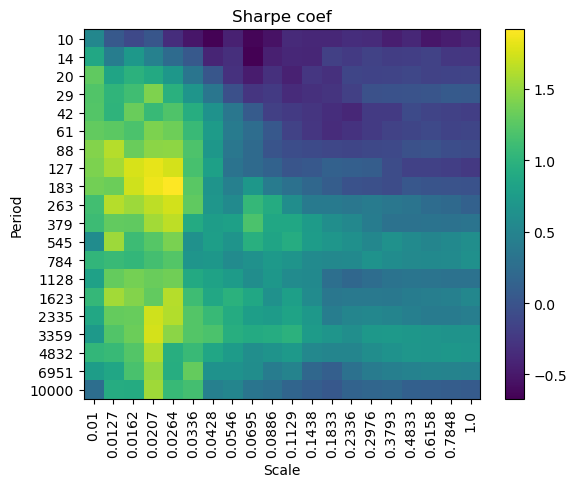

In [67]:
stats_pivot = stats.pivot(index = 'period', columns = 'scale', values = 'Sharpe ratio')

plt.imshow(stats_pivot, aspect = 'auto', interpolation = 'none')
plt.xticks(np.arange(len(scales)), scales, rotation = 90)
plt.yticks(np.arange(len(periods)), periods)
plt.title('Sharpe coef')
plt.xlabel('Scale')
plt.ylabel('Period')

_ = plt.colorbar()

p = True
if p == True:
    plt.show()
    p = False

Best set of parameters:

In [68]:
temp = stats_pivot.values
amax = temp.argmax()
row, col = (amax//temp.shape[1], amax%temp.shape[1])
print('Sharpe ratio = ', stats_pivot.iloc[row, col])
print('Period = ', stats_pivot.index[row], 'Scale = ', stats_pivot.columns[col])

best_is_stats = stats.sort_values('Sharpe ratio', ascending = False).iloc[0]

Sharpe ratio =  1.9170259174787587
Period =  183 Scale =  0.0264


We calculate equity on data that includes a test period:

Sharpe ratio = 1.69
Annual Return = 0.19
Annual Std = 0.12


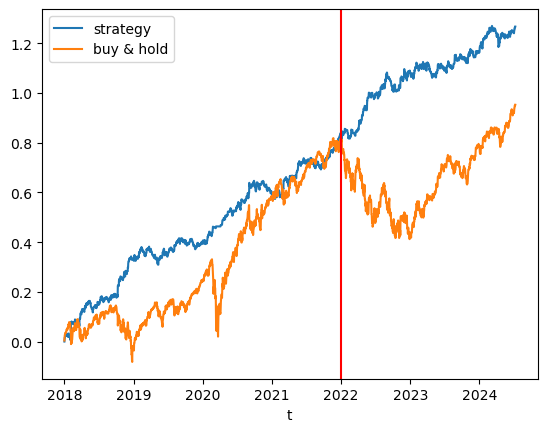

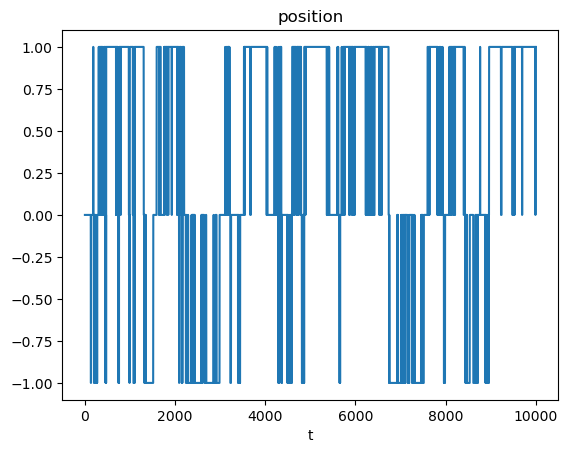

In [13]:
_, eq = strategy_backtest(train_test, [best_is_stats['period'].astype(int), best_is_stats['scale']], True, in_sample_end)

p = True
if p == True:
    plt.show()
    p = False

Calculate statistics on test data:

Sharpe ratio = 1.38
Annual Return = 0.17
Annual Std = 0.12


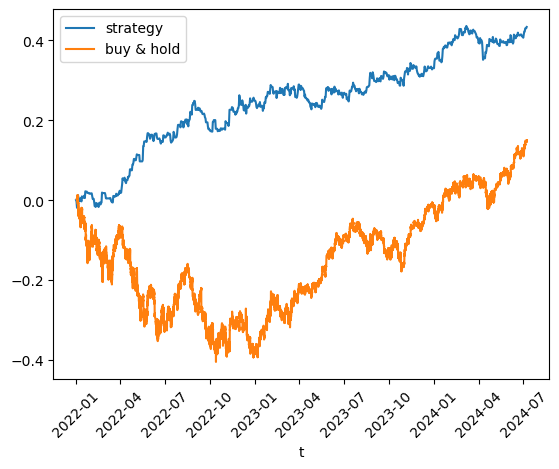

In [14]:
statistics_calc(eq[in_sample_end:], test, name = "{0}_{1}".format(period, scale), plot = True)
_=plt.xticks(rotation = 45)
p = True
if p == True:
    plt.show()
    p = False

Creating a report using pyfolio

Start date,2018-01-01
End date,2024-07-08
Total months,113
,Backtest
Annual return,13.837%
Cumulative returns,240.253%
Annual volatility,9.561%
Sharpe ratio,1.40
Calmar ratio,1.68
Stability,0.99
Max drawdown,-8.221%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,8.22,2024-03-07,2024-04-10,NaT,NaN
1,7.45,2022-08-30,2022-10-05,2022-11-30,67
2,7.18,2020-09-28,2021-01-17,2021-03-09,117
3,7.05,2019-03-24,2019-05-10,2019-08-05,96
4,6.29,2023-03-09,2023-04-26,2023-08-23,120


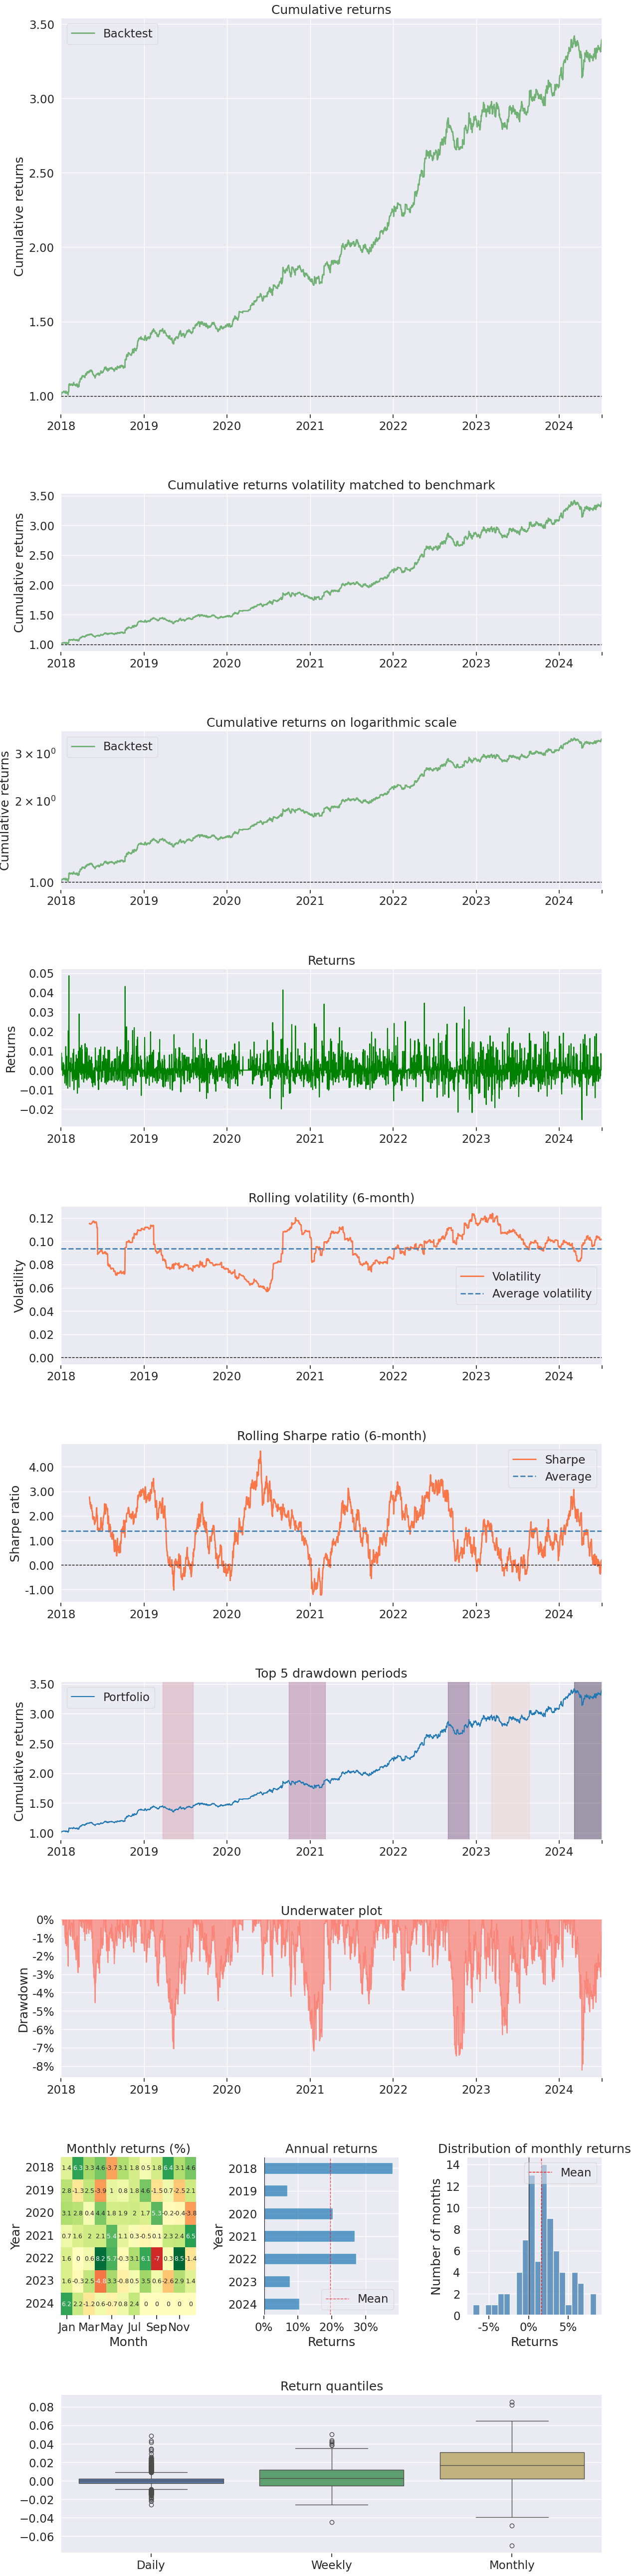

In [15]:
# Disabling compatibility errors
import warnings
warnings.filterwarnings('ignore')
import pyfolio as pf #if you haven't got pyfolio installed, run !pip install pyfolio_reloaded

pd.Series.iteritems = pd.Series.items

figs = pf.create_returns_tear_sheet(eq, return_fig=True) 

p = True
if p == True:
    plt.show()
    p = False

Additional exercises and research topics:

1.  Optimize all strategy parameters. Study the sensitivity of strategy to small changes in parameters.
2.  Test the strategy on other timeframes and instruments.
3.  Try using other parametric families of functions (trend-following indicators) to form the target position.
4.  Implement a walk-forward optimization scheme.
5.  Construct a portfolio of strategies.



Before we had this score:

Sharpe ratio = 1.38
Annual Return = 0.17
Annual Std = 0.12


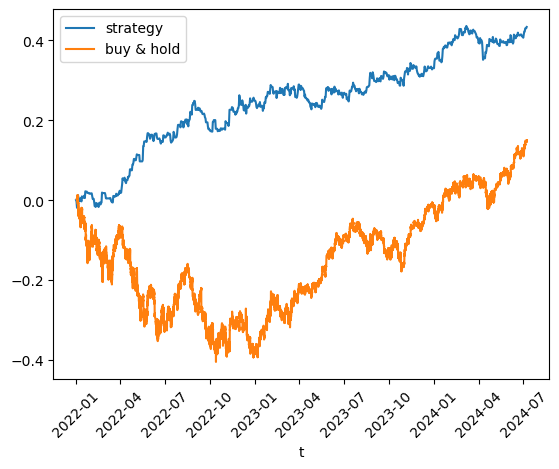

In [16]:
statistics_calc(eq[in_sample_end:], test, name = "{0}_{1}".format(period, scale), plot = True)
_=plt.xticks(rotation = 45)

## 1. LET’S OPTIMIZE STRATEGY PARAMETERS:


The best result was with:
1) period = 183
2) Scale = 0.0264

So, we will try to find better params near this values, because the best ratio could be near according to heatmap:

In [142]:
periods = np.arange(120, 231)  
scales = np.logspace(-3.0, -1, num=50).round(7)

print('Periods: ',periods)
print('Scales: ', scales)

Periods:  [120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137
 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155
 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173
 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191
 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209
 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227
 228 229 230]
Scales:  [0.001     0.0010985 0.0012068 0.0013257 0.0014563 0.0015999 0.0017575
 0.0019307 0.002121  0.00233   0.0025595 0.0028118 0.0030888 0.0033932
 0.0037276 0.0040949 0.0044984 0.0049417 0.0054287 0.0059636 0.0065513
 0.0071969 0.007906  0.0086851 0.009541  0.0104811 0.011514  0.0126486
 0.013895  0.0152642 0.0167683 0.0184207 0.0202359 0.02223   0.0244205
 0.026827  0.0294705 0.0323746 0.0355648 0.0390694 0.0429193 0.0471487
 0.0517947 0.0568987 0.0625055 0.0686649 0.0754312 0.0828643 0.0910298
 0.1      ]


In [143]:
stats = pd.DataFrame()

for period in tqdm(periods):
    for scale in scales:
        stats_current, _ = strategy_backtest(train, [period, scale])
        if stats.shape[0] == 0:
            stats = stats_current
        else:
            stats = pd.concat([stats, stats_current])

  0%|          | 0/111 [00:00<?, ?it/s]

In [144]:
stats

,Sharpe ratio,Annual return,Volatility,period,scale
120_0.001,-0.500171,-0.001228,0.002455,120,0.001000
120_0.0010985,-0.534893,-0.001316,0.002461,120,0.001099
120_0.0012068,-0.538710,-0.001327,0.002462,120,0.001207
120_0.0013257,-0.228190,-0.000636,0.002789,120,0.001326
120_0.0014563,0.185877,0.000821,0.004417,120,0.001456
...,...,...,...,...,...
230_0.0686649,0.812246,0.123081,0.151532,230,0.068665
230_0.0754312,0.660614,0.103598,0.156821,230,0.075431
230_0.0828643,0.734773,0.114942,0.156432,230,0.082864
230_0.0910298,0.689795,0.110488,0.160175,230,0.091030


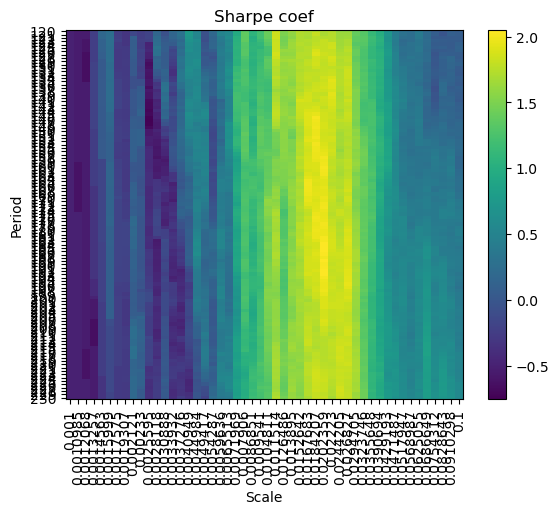

In [145]:
stats_pivot = stats.pivot(index = 'period', columns = 'scale', values = 'Sharpe ratio')

plt.imshow(stats_pivot, aspect = 'auto', interpolation = 'none')
plt.xticks(np.arange(len(scales)), scales, rotation = 90)
plt.yticks(np.arange(len(periods)), periods)
plt.title('Sharpe coef')
plt.xlabel('Scale')
plt.ylabel('Period')

_ = plt.colorbar()

p = True
if p == True:
    plt.show()
    p = False

In [146]:
temp = stats_pivot.values
amax = temp.argmax()
row, col = (amax//temp.shape[1], amax%temp.shape[1])
print('Sharpe ratio = ', stats_pivot.iloc[row, col])
print('Period = ', stats_pivot.index[row], 'Scale = ', stats_pivot.columns[col])

best_is_stats = stats.sort_values('Sharpe ratio', ascending = False).iloc[0]

Sharpe ratio =  2.0513750533840036
Period =  185 Scale =  0.0202359


Now the sharpe ratio is 2.05 that is much higher than before, if we will have a look at heatmap we will see, that we can't find better params.

Also we can see a gradient in sharpe ratio with Scale changing from 0.001 to 0.1

Sharpe ratio = 1.80
Annual Return = 0.17
Annual Std = 0.10


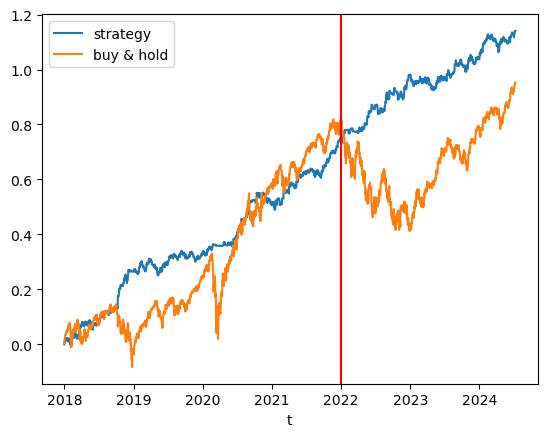

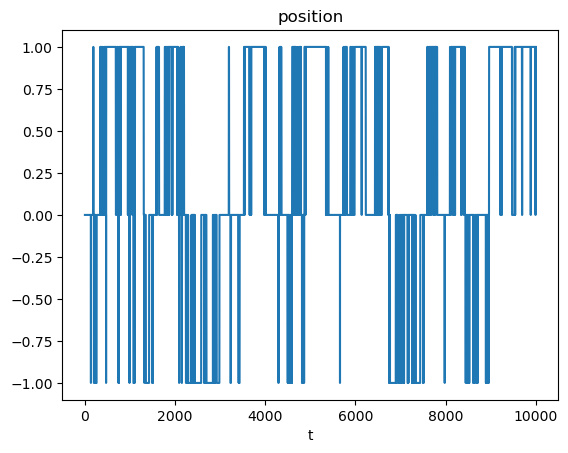

In [154]:
_, eq = strategy_backtest(train_test, [best_is_stats['period'].astype(int), best_is_stats['scale']], True, in_sample_end)

p = True
if p == True:
    plt.show()
    p = False

Just on test:
(before we had ratio = 1.38, so we could find better hyperparametrs)

Sharpe ratio = 1.48
Annual Return = 0.16
Annual Std = 0.11


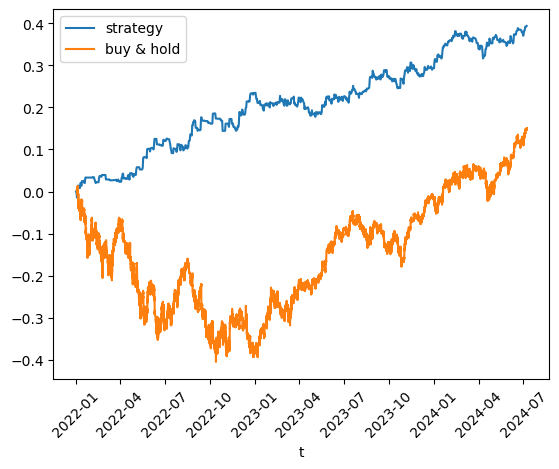

In [155]:
statistics_calc(eq[in_sample_end:], test, name = "{0}_{1}".format(period, scale), plot = True)
_=plt.xticks(rotation = 45)
p = True
if p == True:
    plt.show()
    p = False

In [150]:
periods = np.arange(170, 211)  
scales = np.logspace(-2.0, -1, num=20).round(5)

print('Periods: ',periods)
print('Scales: ', scales)

Periods:  [170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187
 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205
 206 207 208 209 210]
Scales:  [0.01    0.01129 0.01274 0.01438 0.01624 0.01833 0.02069 0.02336 0.02637
 0.02976 0.0336  0.03793 0.04281 0.04833 0.05456 0.06158 0.06952 0.07848
 0.08859 0.1    ]


In [151]:
stats = pd.DataFrame()

for period in tqdm(periods):
    for scale in scales:
        stats_current, _ = strategy_backtest(train, [period, scale])
        if stats.shape[0] == 0:
            stats = stats_current
        else:
            stats = pd.concat([stats, stats_current])

  0%|          | 0/41 [00:00<?, ?it/s]

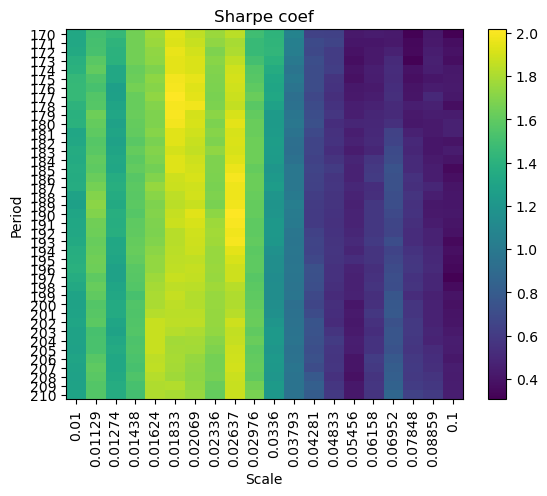

In [152]:
stats_pivot = stats.pivot(index = 'period', columns = 'scale', values = 'Sharpe ratio')

plt.imshow(stats_pivot, aspect = 'auto', interpolation = 'none')
plt.xticks(np.arange(len(scales)), scales, rotation = 90)
plt.yticks(np.arange(len(periods)), periods)
plt.title('Sharpe coef')
plt.xlabel('Scale')
plt.ylabel('Period')

_ = plt.colorbar()

p = True
if p == True:
    plt.show()
    p = False

If we change scale from 0.029 to 0.03 there is a big gradient in sharpe coeff

## 2. LET’S Test the strategy on other timeframes and instruments.

2.1 we will change timeframe to hour timeframe

In [163]:
data_hourly = data['log_ret'].resample('1H').sum().to_frame('log_ret')

In [161]:
data = data_hourly

In [164]:
in_sample_start = '2018-01-01'
in_sample_end = '2022-01-01'

train = data[in_sample_start:in_sample_end]
test = data[in_sample_end:]
train_test = data[in_sample_start:]

In [183]:
periods = np.arange(5000, 6000, 20)
scales = np.logspace(-1.7, -1.0, num = 20).round(4)

print('Periods: ',periods)
print('Scales: ', scales)

Periods:  [5000 5020 5040 5060 5080 5100 5120 5140 5160 5180 5200 5220 5240 5260
 5280 5300 5320 5340 5360 5380 5400 5420 5440 5460 5480 5500 5520 5540
 5560 5580 5600 5620 5640 5660 5680 5700 5720 5740 5760 5780 5800 5820
 5840 5860 5880 5900 5920 5940 5960 5980]
Scales:  [0.02   0.0217 0.0236 0.0257 0.028  0.0305 0.0332 0.0361 0.0393 0.0428
 0.0466 0.0507 0.0552 0.0601 0.0654 0.0712 0.0775 0.0844 0.0919 0.1   ]


In [184]:
stats = pd.DataFrame()

for period in tqdm(periods):
    for scale in scales:
        stats_current, _ = strategy_backtest(train, [period, scale])
        if stats.shape[0] == 0:
            stats = stats_current
        else:
            stats = pd.concat([stats, stats_current])

  0%|          | 0/50 [00:00<?, ?it/s]

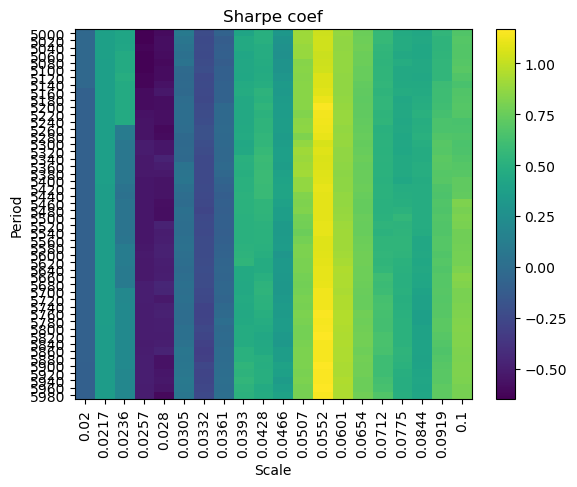

In [185]:
stats_pivot = stats.pivot(index = 'period', columns = 'scale', values = 'Sharpe ratio')

plt.imshow(stats_pivot, aspect = 'auto', interpolation = 'none')
plt.xticks(np.arange(len(scales)), scales, rotation = 90)
plt.yticks(np.arange(len(periods)), periods)
plt.title('Sharpe coef')
plt.xlabel('Scale')
plt.ylabel('Period')

_ = plt.colorbar()

p = True
if p == True:
    plt.show()
    p = False

In [186]:
temp = stats_pivot.values
amax = temp.argmax()
row, col = (amax//temp.shape[1], amax%temp.shape[1])
print('Sharpe ratio = ', stats_pivot.iloc[row, col])
print('Period = ', stats_pivot.index[row], 'Scale = ', stats_pivot.columns[col])

best_is_stats = stats.sort_values('Sharpe ratio', ascending = False).iloc[0]

Sharpe ratio =  1.1674763888292934
Period =  5960 Scale =  0.0552


It is strange, that we could't achieve the same result in sharpe ratio, because the timeframe does not affect, because we calculate it annually

let's try daily timeframe:

In [189]:
data_daily = data['log_ret'].resample('1D').sum().to_frame('log_ret')

In [190]:
data = data_daily

In [191]:
in_sample_start = '2018-01-01'
in_sample_end = '2022-01-01'

train = data[in_sample_start:in_sample_end]
test = data[in_sample_end:]
train_test = data[in_sample_start:]

In [225]:
periods = np.arange(3000, 6000, 50)
scales = np.logspace(0.9, 2.3, num = 20).round(4)

print('Periods: ',periods)
print('Scales: ', scales)

Periods:  [3000 3050 3100 3150 3200 3250 3300 3350 3400 3450 3500 3550 3600 3650
 3700 3750 3800 3850 3900 3950 4000 4050 4100 4150 4200 4250 4300 4350
 4400 4450 4500 4550 4600 4650 4700 4750 4800 4850 4900 4950 5000 5050
 5100 5150 5200 5250 5300 5350 5400 5450 5500 5550 5600 5650 5700 5750
 5800 5850 5900 5950]
Scales:  [  7.9433   9.412   11.1524  13.2146  15.658   18.5533  21.9839  26.0489
  30.8655  36.5728  43.3353  51.3483  60.843   72.0933  85.4238 101.2193
 119.9354 142.1123 168.3898 199.5262]


In [226]:
stats = pd.DataFrame()

for period in tqdm(periods):
    for scale in scales:
        stats_current, _ = strategy_backtest(train, [period, scale])
        if stats.shape[0] == 0:
            stats = stats_current
        else:
            stats = pd.concat([stats, stats_current])

  0%|          | 0/60 [00:00<?, ?it/s]

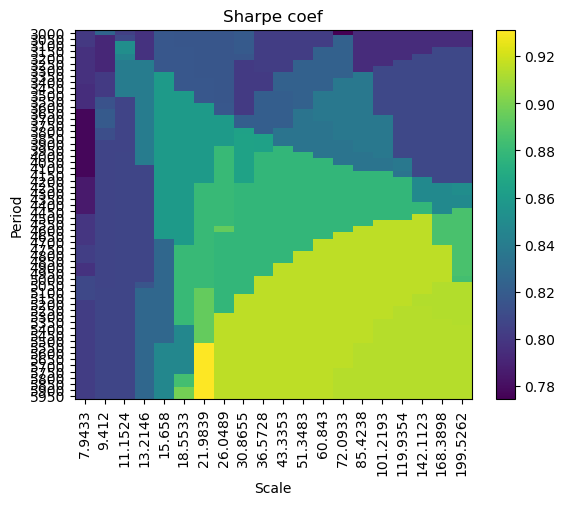

In [227]:
stats_pivot = stats.pivot(index = 'period', columns = 'scale', values = 'Sharpe ratio')

plt.imshow(stats_pivot, aspect = 'auto', interpolation = 'none')
plt.xticks(np.arange(len(scales)), scales, rotation = 90)
plt.yticks(np.arange(len(periods)), periods)
plt.title('Sharpe coef')
plt.xlabel('Scale')
plt.ylabel('Period')

_ = plt.colorbar()

p = True
if p == True:
    plt.show()
    p = False

In [228]:
temp = stats_pivot.values
amax = temp.argmax()
row, col = (amax//temp.shape[1], amax%temp.shape[1])
print('Sharpe ratio = ', stats_pivot.iloc[row, col])
print('Period = ', stats_pivot.index[row], 'Scale = ', stats_pivot.columns[col])

best_is_stats = stats.sort_values('Sharpe ratio', ascending = False).iloc[0]

Sharpe ratio =  0.9312906472142243
Period =  5550 Scale =  21.9839


Now we have the same result as that that we had in hour timeframe

I think this difference may occur due to high rmse error because it is estimated the Sharpe ratio inversely proportional to the root of the length of the time period. as we know from the 2 lecture

In [229]:
best_is_stats = stats.sort_values('Sharpe ratio', ascending = False).iloc[0]

In [230]:
print(best_is_stats)

Sharpe ratio        0.931291
Annual return       0.190741
Volatility          0.204814
period           5750.000000
scale              21.983900
Name: 5750_21.9839, dtype: float64


## 3.Let's try to use other parametric families of functions (trend-following indicators) to form the target position.

In [231]:
data = read_data('NQ')
in_sample_start = '2018-01-01'
in_sample_end = '2022-01-01'

train = data[in_sample_start:in_sample_end]
test = data[in_sample_end:]
train_test = data[in_sample_start:]

In [232]:
data

,log_ret
date,
2018-01-01 18:00:00,0.003290
2018-01-01 18:05:00,0.000281
2018-01-01 18:10:00,-0.000063
2018-01-01 18:15:00,-0.000063
2018-01-01 18:20:00,0.000188
...,...
2024-07-08 11:10:00,0.000048
2024-07-08 11:15:00,0.000497
2024-07-08 11:20:00,0.001029


We will try to use Macd indicator:
the main idea is to find the intersection between fast and slow.
If MACD > => signal to buy and so on

In [260]:
def strategy_backtest_macd(data, params, plot=False, in_sample_end='', slippage=1e-5):
    """
    Strategy backtest using MACD-based signal

    ::data: dataframe with log returns
    :params: [p_fast, p_slow, p_signal, scale]

    :return: statistics and equity curve
    """

    p_fast, p_slow, p_signal, scale = params
    pos_limit = 1

    # Calculation of target position:
    features = pd.DataFrame(index=data.index)

    # MACD
    ema_fast = data['log_ret'].ewm(span=p_fast, adjust=False).mean()
    ema_slow = data['log_ret'].ewm(span=p_slow, adjust=False).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=p_signal, adjust=False).mean()
    raw_sig = (macd_line - signal_line) * scale
    
    
    # Shift to avoid lookahead
    features['signal'] = raw_sig.shift(1)

    features['position'] = np.sign(features['signal'])  # +1 / 0 / -1
    
    features['position'] = features['position'].shift(1).fillna(0).astype(int)

    pnl = data['log_ret'] * features['position']
    
    costs = slippage * features['position'].diff().abs()
    eq = (pnl - costs).fillna(0).resample('1D').sum()
    bh = data['log_ret'].fillna(0).resample('1D').sum()
    stats = statistics_calc(eq, bh, name=f"MACD_{p_fast}_{p_slow}_{p_signal}_{scale}", plot=plot)
    
    stats['p_fast'] = p_fast
    stats['p_slow'] = p_slow
    stats['p_signal'] = p_signal
    stats['scale'] = scale

    return stats, eq


In [278]:
p_fast_opts   = [4, 8, 12, 16, 20]                    
p_slow_opts   = [24, 26, 30, 34]                    
p_signal_opts = [6, 9, 12]                         
scale_opts    = np.linspace(0.5, 2.0, 7).round(2)   


results = []
for p_fast in tqdm(p_fast_opts, desc='p_fast'):
    for p_slow in p_slow_opts:
        if p_slow <= p_fast:
            continue
        for p_signal in p_signal_opts:
            for scale in scale_opts:
                stats, _ = strategy_backtest_macd(
                    data=train, 
                    params=[p_fast, p_slow, p_signal, scale],
                    plot=False
                )
                d = {
                    'Sharpe': stats['Sharpe ratio'],
                    'p_fast': p_fast,
                    'p_slow': p_slow,
                    'p_signal': p_signal,
                    'scale': scale,
                    'sharpe': stats.iloc[0]['Sharpe ratio']
                }
                results.append(d)

df = pd.DataFrame(results)



p_fast:   0%|          | 0/5 [00:00<?, ?it/s]

In [279]:
df

,Sharpe,p_fast,p_slow,p_signal,scale,sharpe
0,MACD_4_24_6_0.5 -4.316018 Name: Sharpe ratio...,4,24,6,0.50,-4.316018
1,MACD_4_24_6_0.75 -4.316018 Name: Sharpe rati...,4,24,6,0.75,-4.316018
2,MACD_4_24_6_1.0 -4.316018 Name: Sharpe ratio...,4,24,6,1.00,-4.316018
3,MACD_4_24_6_1.25 -4.316018 Name: Sharpe rati...,4,24,6,1.25,-4.316018
4,MACD_4_24_6_1.5 -4.316018 Name: Sharpe ratio...,4,24,6,1.50,-4.316018
...,...,...,...,...,...,...
415,MACD_20_34_12_1.0 -1.240226 Name: Sharpe rat...,20,34,12,1.00,-1.240226
416,MACD_20_34_12_1.25 -1.240226 Name: Sharpe ra...,20,34,12,1.25,-1.240226
417,MACD_20_34_12_1.5 -1.240226 Name: Sharpe rat...,20,34,12,1.50,-1.240226
418,MACD_20_34_12_1.75 -1.240226 Name: Sharpe ra...,20,34,12,1.75,-1.240226


In [284]:
best_df = df[df['sharpe'] == df['sharpe'].max()]

print(best_df[['p_fast', 'p_slow', 'p_signal', 'scale', 'sharpe']])


     p_fast  p_slow  p_signal  scale    sharpe
413      20      34        12   0.50 -1.240226
414      20      34        12   0.75 -1.240226
415      20      34        12   1.00 -1.240226
416      20      34        12   1.25 -1.240226
417      20      34        12   1.50 -1.240226
418      20      34        12   1.75 -1.240226
419      20      34        12   2.00 -1.240226


we need to optimize hyperparameters

In [285]:
p_fast_opts   = [20, 21, 22, 23, 24, 25, 26, 50, 60]                    
p_slow_opts   = [34, 36, 38, 40, 50, 60, 100, 400, 1000]                    
p_signal_opts = [12, 14, 20, 30]                         
scale_opts    = np.linspace(0.5, 2.0, 7).round(2)   


results = []
for p_fast in tqdm(p_fast_opts, desc='p_fast'):
    for p_slow in p_slow_opts:
        if p_slow <= p_fast:
            continue
        for p_signal in p_signal_opts:
            for scale in scale_opts:
                stats, _ = strategy_backtest_macd(
                    data=train, 
                    params=[p_fast, p_slow, p_signal, scale],
                    plot=False
                )
                d = {
                    'Sharpe': stats['Sharpe ratio'],
                    'p_fast': p_fast,
                    'p_slow': p_slow,
                    'p_signal': p_signal,
                    'scale': scale,
                    'sharpe': stats.iloc[0]['Sharpe ratio']
                }
                results.append(d)

df = pd.DataFrame(results)



p_fast:   0%|          | 0/9 [00:00<?, ?it/s]

In [286]:
best_df = df[df['sharpe'] == df['sharpe'].max()]

print(best_df[['p_fast', 'p_slow', 'p_signal', 'scale', 'sharpe']])


      p_fast  p_slow  p_signal  scale   sharpe
1813      50     100        30   0.50  0.04896
1814      50     100        30   0.75  0.04896
1815      50     100        30   1.00  0.04896
1816      50     100        30   1.25  0.04896
1817      50     100        30   1.50  0.04896
1818      50     100        30   1.75  0.04896
1819      50     100        30   2.00  0.04896


now results are better, but we need to make them better

In [287]:
p_fast_opts   = [40, 50, 60]                    
p_slow_opts   = [80, 90, 100, 110, 120]                    
p_signal_opts = [30, 50, 70, 100, 1000]                         
scale_opts    = np.linspace(0.5, 2.0, 7).round(2)   


results = []
for p_fast in tqdm(p_fast_opts, desc='p_fast'):
    for p_slow in p_slow_opts:
        if p_slow <= p_fast:
            continue
        for p_signal in p_signal_opts:
            for scale in scale_opts:
                stats, _ = strategy_backtest_macd(
                    data=train, 
                    params=[p_fast, p_slow, p_signal, scale],
                    plot=False
                )
                d = {
                    'Sharpe': stats['Sharpe ratio'],
                    'p_fast': p_fast,
                    'p_slow': p_slow,
                    'p_signal': p_signal,
                    'scale': scale,
                    'sharpe': stats.iloc[0]['Sharpe ratio']
                }
                results.append(d)

df = pd.DataFrame(results)



p_fast:   0%|          | 0/3 [00:00<?, ?it/s]

In [288]:
best_df = df[df['sharpe'] == df['sharpe'].max()]

print(best_df[['p_fast', 'p_slow', 'p_signal', 'scale', 'sharpe']])


     p_fast  p_slow  p_signal  scale    sharpe
308      50     110      1000   0.50  0.648758
309      50     110      1000   0.75  0.648758
310      50     110      1000   1.00  0.648758
311      50     110      1000   1.25  0.648758
312      50     110      1000   1.50  0.648758
313      50     110      1000   1.75  0.648758
314      50     110      1000   2.00  0.648758


GOOOD!!! Lets go !

In [289]:
p_fast_opts   = [48,49, 50, 51, 52, 53]                    
p_slow_opts   = [101, 103, 107, 109 ,110, 113]                    
p_signal_opts = [1000, 1200, 10000, 100_000]                         
scale_opts    = np.linspace(0.5, 2.0, 7).round(2)   


results = []
for p_fast in tqdm(p_fast_opts, desc='p_fast'):
    for p_slow in p_slow_opts:
        if p_slow <= p_fast:
            continue
        for p_signal in p_signal_opts:
            for scale in scale_opts:
                stats, _ = strategy_backtest_macd(
                    data=train, 
                    params=[p_fast, p_slow, p_signal, scale],
                    plot=False
                )
                d = {
                    'Sharpe': stats['Sharpe ratio'],
                    'p_fast': p_fast,
                    'p_slow': p_slow,
                    'p_signal': p_signal,
                    'scale': scale,
                    'sharpe': stats.iloc[0]['Sharpe ratio']
                }
                results.append(d)

df = pd.DataFrame(results)



p_fast:   0%|          | 0/6 [00:00<?, ?it/s]

In [290]:
best_df = df[df['sharpe'] == df['sharpe'].max()]

print(best_df[['p_fast', 'p_slow', 'p_signal', 'scale', 'sharpe']])


     p_fast  p_slow  p_signal  scale    sharpe
784      52     110      1000   0.50  0.770313
785      52     110      1000   0.75  0.770313
786      52     110      1000   1.00  0.770313
787      52     110      1000   1.25  0.770313
788      52     110      1000   1.50  0.770313
789      52     110      1000   1.75  0.770313
790      52     110      1000   2.00  0.770313


Good job!

In [291]:
p_fast_opts   = [48,49, 50, 51, 52, 53, 54, 55]                    
p_slow_opts   = [109, 110, 111, 112]                    
p_signal_opts = [1000, 1020, 1030, 1040, 1050, 1100]                         
scale_opts    = np.linspace(0.5, 2.0, 7).round(2)   


results = []
for p_fast in tqdm(p_fast_opts, desc='p_fast'):
    for p_slow in p_slow_opts:
        if p_slow <= p_fast:
            continue
        for p_signal in p_signal_opts:
            for scale in scale_opts:
                stats, _ = strategy_backtest_macd(
                    data=train, 
                    params=[p_fast, p_slow, p_signal, scale],
                    plot=False
                )
                d = {
                    'Sharpe': stats['Sharpe ratio'],
                    'p_fast': p_fast,
                    'p_slow': p_slow,
                    'p_signal': p_signal,
                    'scale': scale,
                    'sharpe': stats.iloc[0]['Sharpe ratio']
                }
                results.append(d)

df = pd.DataFrame(results)



p_fast:   0%|          | 0/8 [00:00<?, ?it/s]

In [292]:
best_df = df[df['sharpe'] == df['sharpe'].max()]

print(best_df[['p_fast', 'p_slow', 'p_signal', 'scale', 'sharpe']])


     p_fast  p_slow  p_signal  scale    sharpe
714      52     110      1000   0.50  0.770313
715      52     110      1000   0.75  0.770313
716      52     110      1000   1.00  0.770313
717      52     110      1000   1.25  0.770313
718      52     110      1000   1.50  0.770313
719      52     110      1000   1.75  0.770313
720      52     110      1000   2.00  0.770313


Ok, i think this is the best :)

Now let's compare it with buy and hold:

Just test period:

Sharpe ratio = 1.48
Annual Return = 0.16
Annual Std = 0.11


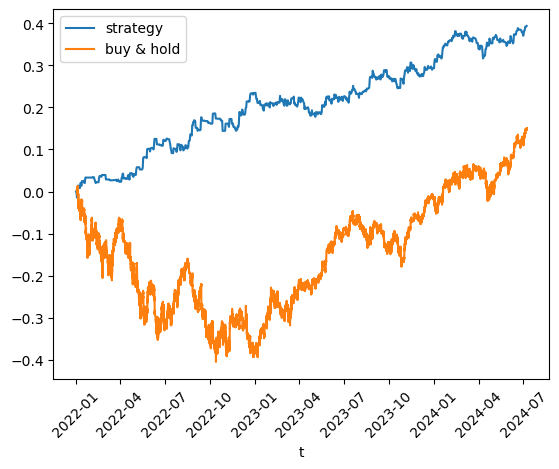

In [293]:
statistics_calc(eq[in_sample_end:], test, name = "{0}_{1}".format(period, scale), plot = True)
_=plt.xticks(rotation = 45)
p = True
if p == True:
    plt.show()
    p = False

our strategy is better than buy and hold, i am happy :)